# Simple Sentiment Classification: Bag of Words

In this notebook, we consider *sentiment classification*, a standard task in natural language processing. Based on a review of a movie (or a restaurant, hotel, etc.), we want to predict whether the person liked the movie or not. As an example, we use a data set provided by the International Movie Database website www.imdb.com. The provided reviews are labeled with a binary rating whether they are positive (label 1) or negative (label 0).

## Set-up
First of all, we need to load the libraries that we will need for this task. We will use keras and tensorflow for this code example, so we load the relevant parts of this framework:

In [1]:
!pip install tensorflow_datasets

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

2025-09-15 14:58:06.085400: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-15 14:58:06.119638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-15 14:58:06.119669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-15 14:58:06.120653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-15 14:58:06.126744: I tensorflow/core/platform/cpu_feature_guar

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Input, TextVectorization, Embedding, Conv1D, Flatten, LSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant

In [4]:
# initialize random number generators to ensure reproducibility:
tf.random.set_seed(123)
np.random.seed(123)

In [5]:
# some more general libraries for evaluation purposes:
import matplotlib.pyplot as plt
import datetime

In [6]:
# set some model parameters
VOCAB_SIZE = 5000
NUM_EPOCHS = 50 # set lower for fast results - set higher for good results
BUFFER_SIZE = 500
BATCH_SIZE = 500
EMBED_DIM = 100
MAX_LEN = 200

In [7]:
# Configurations
tf.config.run_functions_eagerly(True)

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Loading the Data
The IMDb data set is available via the library `tensorflow_datasets`, which allows for easy access. The data is already split into a TRAIN and TEST set, each containing 25'000 labeled reviews. In order to obtain also a validation set, we further divide the TRAIN data set into 80% training and 20% validation data. The labels come directly with the respective texts:

In [8]:
train_ds, val_ds, test_ds = tfds.load(
    name = "imdb_reviews",
    split = [ 'train[:80%]', 'train[80%:]', 'test' ],
    as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/jovyan/tensorflow_datasets/imdb_reviews/plain_text/incomplete.IJW0AC_1.0.0/imdb_reviews-train.…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/jovyan/tensorflow_datasets/imdb_reviews/plain_text/incomplete.IJW0AC_1.0.0/imdb_reviews-test.t…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/jovyan/tensorflow_datasets/imdb_reviews/plain_text/incomplete.IJW0AC_1.0.0/imdb_reviews-unsupe…

Dataset imdb_reviews downloaded and prepared to /home/jovyan/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


/home/jovyan/tensorflow-venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


The data sets are of a special data type which is optimized for handling large amounts of data and processing them on mulitple machines in parallel. We can get the number of samples as follows:

In [9]:
train_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=20000>

First we look at some examples from the training data set:

In [10]:
for example, label in train_ds.take(5):
  print("Input: ", example)
  print(10*".")
  print('Target labels: ', label)
  print(50*"-")

Input:  tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
..........
Target labels:  tf.Tensor(0, shape=(), dtype=int64)
--------------------------------------------------
Input:  tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, r

2025-09-15 14:58:41.129287: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Text Representation: Bag of Words
The text is raw text, without a lot of formatting, but it also includes some html tags. For a first try, we will start with a simple `TextVectorization` layer, that is similar to a bag of word. We will use a vocabulary size of 5000 words:

In [11]:
encoderBoW = TextVectorization(output_mode = "count", max_tokens=VOCAB_SIZE)
encoderBoW.adapt(train_ds.map(lambda text, label: text))

The `.adapt()` method chooses the vocabulary of the layer based on the training data - this corresponds to a kind of training, but is done in an explicit step (essentially counting and sorting). The function `map(lambda text, label: text)` ensures that we only use the texts from the `train_ds` data set (and leave out the labels for the moment).

As we work with a `VOCAB_SIZE` of 5000, chances are high that some of the words will not be represented in the vocabulary. The `.adapt()` will return the most common 4999 words, and all  other words are represented as `[UNK]` (for *unknown*). The tokens are sorted in descending order of frequency. Here are the first 20 tokens (i.e., the most frequent ones):

In [12]:
vocab = np.array(encoderBoW.get_vocabulary())
vocab[:20]

array(['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but',
       'film'], dtype='<U16')

The first word in the vocabulary is `[UNK]`, the token for the unknown words. Afterwards, we have a number of token for very common words, the so-called **stop words**. The first one being 'the'. So, in the numerical vector that we get after coding, the first column corresponds to all unknown words (i.e. all words that do not appear in the vocabulary), and the second column corresponds to the word 'the'. Also some *domain-specific* words occur frequenty: `movie` and `film` indicate that the vocabulary was built on movie reviews.

We can now get an example encoding:

In [13]:
encoderBoW("the")

<tf.Tensor: shape=(5000,), dtype=float32, numpy=array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)>

In [14]:
print(example)

tf.Tensor(b'As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous. The plot very ably shows the hypocrisy of the female libido. When men are around they want to be pursued, but when no "men" are around, they become the pursuers of a 14 year old boy. And the boy becomes a man really fast (we should all be so lucky at this age!). He then gets up the courage to pursue his true love.', shape=(), dtype=string)


In [15]:
encoderBoW(example).numpy()

array([6., 7., 1., ..., 0., 0., 0.], dtype=float32)

# A first Model: Linear Regression
We start with a first, very simple model. It corresponds to a multiple linear regression model, with the 5000-dimensional vector representation of the sentence as input (independent variables, predictors), and the rating (0 or 1) as output (dependent variable, target variable). While this could also be done with a classical regression, we start right away with a neural network, and will extend it gradually as we add more advanced concepts.

## Model Definition

In [16]:
model_BoW_1L_lin = Sequential()
model_BoW_1L_lin.add(Input(shape=(1,), dtype='string'))
model_BoW_1L_lin.add(encoderBoW)
model_BoW_1L_lin.add(Dense(1))

In [17]:
model_BoW_1L_lin.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])

In [18]:
model_BoW_1L_lin.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 5000)              0         
 ctorization)                                                    
                                                                 
 dense (Dense)               (None, 1)                 5001      
                                                                 
Total params: 5001 (19.54 KB)
Trainable params: 5001 (19.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training
Now, let's train the model. We do only a rather small number of epochs and include early stopping in order not to spend too much time on training.

In [19]:
# initialize random number generators to ensure reproducibility:
tf.random.set_seed(123)
np.random.seed(123)

In [20]:
history_BoW_1L_lin = model_BoW_1L_lin.fit(
    train_ds.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE),
    validation_data = val_ds.batch(BATCH_SIZE),
    epochs = NUM_EPOCHS, verbose = 1,
    callbacks = [ EarlyStopping(monitor='val_accuracy', patience=5,
                                verbose=False, restore_best_weights=True)])

Epoch 1/50
40/40 [==============================] - 2s 38ms/step - loss: 2.1423 - accuracy: 0.5920 - val_loss: 1.4577 - val_accuracy: 0.6434
Epoch 2/50
40/40 [==============================] - 1s 36ms/step - loss: 1.0328 - accuracy: 0.7153 - val_loss: 0.8465 - val_accuracy: 0.7370
Epoch 3/50
40/40 [==============================] - 1s 36ms/step - loss: 0.6974 - accuracy: 0.7842 - val_loss: 0.6930 - val_accuracy: 0.7852
Epoch 4/50
40/40 [==============================] - 1s 36ms/step - loss: 0.5654 - accuracy: 0.8246 - val_loss: 0.6508 - val_accuracy: 0.8164
Epoch 5/50
40/40 [==============================] - 1s 36ms/step - loss: 0.4654 - accuracy: 0.8528 - val_loss: 0.6272 - val_accuracy: 0.8340
Epoch 6/50
40/40 [==============================] - 1s 36ms/step - loss: 0.4253 - accuracy: 0.8712 - val_loss: 0.6061 - val_accuracy: 0.8414
Epoch 7/50
40/40 [==============================] - 1s 36ms/step - loss: 0.3820 - accuracy: 0.8832 - val_loss: 0.5802 - val_accuracy: 0.8508
Epoch 8/50
40

40/40 [==============================] - 2s 38ms/step - loss: 1.6614 - accuracy: 0.6071 - val_loss: 1.1046 - val_accuracy: 0.6556
Epoch 2/50
40/40 [==============================] - 1s 36ms/step - loss: 0.9100 - accuracy: 0.7182 - val_loss: 1.0420 - val_accuracy: 0.7398
Epoch 3/50
40/40 [==============================] - 1s 36ms/step - loss: 0.7155 - accuracy: 0.7756 - val_loss: 0.7133 - val_accuracy: 0.7842
Epoch 4/50
40/40 [==============================] - 1s 37ms/step - loss: 0.5532 - accuracy: 0.8193 - val_loss: 0.6739 - val_accuracy: 0.8138
Epoch 5/50
40/40 [==============================] - 1s 36ms/step - loss: 0.5040 - accuracy: 0.8448 - val_loss: 0.8102 - val_accuracy: 0.8216
Epoch 6/50
40/40 [==============================] - 1s 37ms/step - loss: 0.4375 - accuracy: 0.8683 - val_loss: 0.5819 - val_accuracy: 0.8464
Epoch 7/50
40/40 [==============================] - 1s 36ms/step - loss: 0.4086 - accuracy: 0.8763 - val_loss: 0.5807 - val_accuracy: 0.8526
Epoch 8/50
40/40 [======

## Evaluation
Our simple model already has an accuracy of some 84% on the validation data. Let's check the performance on the test data:

In [21]:
results1 = model_BoW_1L_lin.evaluate(test_ds.batch(BATCH_SIZE), verbose=2)

for name, value in zip(model_BoW_1L_lin.metrics_names, results1):
    print("%s: %.3f" % (name, value))

50/50 - 1s - loss: 0.7195 - accuracy: 0.8678 - 1s/epoch - 27ms/step
loss: 0.720
accuracy: 0.868


We get similar performance on the novel test data.

## Interpretation
We want to try to interpret what the model has learned. To do so, we look at the weights that have been inferred.

In [22]:
model_BoW_1L_lin_weights = model_BoW_1L_lin.layers[1].get_weights()[0]
model_BoW_1L_lin_weights

array([[0.00057553],
       [0.00439007],
       [0.00147723],
       ...,
       [0.03862139],
       [0.06510265],
       [0.02934233]], dtype=float32)

`model1_BoW_weights[0]` contains the 5000 weights for the words in the dictionary, while `model1_BoW_weights[1]` is the bias or intercept of the linear regression. We look at the weights and search the indices with the largest values -- these will be the words that are the most positive:


In [23]:
model_BoW_1L_lin_sortOrder = np.argsort(model_BoW_1L_lin_weights, axis=0)
vocab[model_BoW_1L_lin_sortOrder[-5:]]

array([['1010'],
       ['refreshing'],
       ['910'],
       ['810'],
       ['710']], dtype='<U16')

That seems plausible! 

**Exercise:** Find the 5 most negative words that may come from a negative review.

**Solution:**

In [24]:
vocab[model_BoW_1L_lin_sortOrder[:5]]

array([['310'],
       ['410'],
       ['forgettable'],
       ['210'],
       ['disappointment']], dtype='<U16')

**(End of Solution)**

## Evaluate Performance Development
Using the history (which we got from the fit() function), we can also check the evolution of the performance over the training epochs:

In [25]:
history_BoW_1L_lin_dict = history_BoW_1L_lin.history

train_acc_BoW_1L_lin = history_BoW_1L_lin_dict['accuracy']
val_acc_BoW_1L_lin   = history_BoW_1L_lin_dict['val_accuracy']

train_loss_BoW_1L_lin = history_BoW_1L_lin_dict['loss']
val_loss_BoW_1L_lin   = history_BoW_1L_lin_dict['val_loss']

epochs_BoW_1L_lin    = range(1, len(train_acc_BoW_1L_lin) + 1)

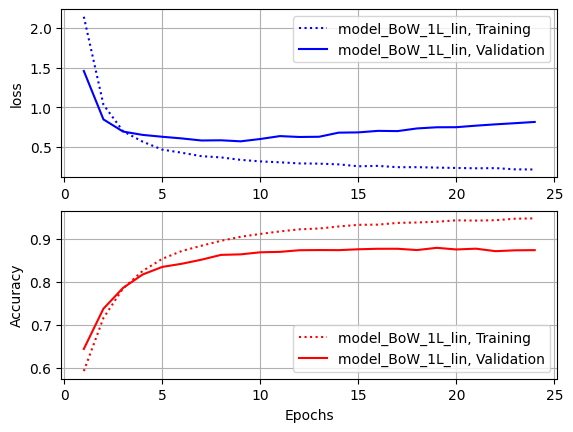

In [26]:
plt.subplot(2, 1, 1)
plt.plot(epochs_BoW_1L_lin, train_loss_BoW_1L_lin, 'b:', label='model_BoW_1L_lin, Training')
plt.plot(epochs_BoW_1L_lin, val_loss_BoW_1L_lin,   'b',  label='model_BoW_1L_lin, Validation')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs_BoW_1L_lin, train_acc_BoW_1L_lin, 'r:', label='model_BoW_1L_lin, Training')
plt.plot(epochs_BoW_1L_lin, val_acc_BoW_1L_lin,   'r',  label='model_BoW_1L_lin, Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# A slightly more advanced Model: Logistic Regression
As the output is binary, we might also see the task as binary classification, and logistic regression seems a natural choice. In the model above, we only need to change the activation function to `sigmoid`, and we already have a neural network doing logistic regression:

In [27]:
# initialize random number generators to ensure reproducibility:
tf.random.set_seed(123)
np.random.seed(123)

In [28]:
model_BoW_1L_sig = Sequential()
model_BoW_1L_sig.add(Input(shape=(1,), dtype='string'))
model_BoW_1L_sig.add(encoderBoW)
model_BoW_1L_sig.add(Dense(1, activation="sigmoid"))

In [29]:
model_BoW_1L_sig.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])

In [30]:
history_BoW_1L_sig = model_BoW_1L_sig.fit(
    train_ds.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE),
    validation_data = val_ds.batch(BATCH_SIZE),
    epochs = NUM_EPOCHS, verbose = 1,
    callbacks = [ EarlyStopping(monitor='val_accuracy', patience=5,
                                verbose=False, restore_best_weights=True)])

# Evaluate Training Progress
history_BoW_1L_sig_dict = history_BoW_1L_sig.history

train_acc_BoW_1L_sig = history_BoW_1L_sig_dict['accuracy']
val_acc_BoW_1L_sig   = history_BoW_1L_sig_dict['val_accuracy']
epochs_BoW_1L_sig    = range(1, len(train_acc_BoW_1L_sig) + 1)

Epoch 1/50
40/40 [==============================] - 2s 36ms/step - loss: 0.6055 - accuracy: 0.7027 - val_loss: 0.5336 - val_accuracy: 0.8002
Epoch 2/50
40/40 [==============================] - 1s 36ms/step - loss: 0.4845 - accuracy: 0.8385 - val_loss: 0.4600 - val_accuracy: 0.8494
Epoch 3/50
40/40 [==============================] - 1s 37ms/step - loss: 0.4211 - accuracy: 0.8651 - val_loss: 0.4146 - val_accuracy: 0.8658
Epoch 4/50
40/40 [==============================] - 1s 37ms/step - loss: 0.3799 - accuracy: 0.8766 - val_loss: 0.3858 - val_accuracy: 0.8742
Epoch 5/50
40/40 [==============================] - 1s 36ms/step - loss: 0.3490 - accuracy: 0.8860 - val_loss: 0.3635 - val_accuracy: 0.8780
Epoch 6/50
40/40 [==============================] - 1s 36ms/step - loss: 0.3267 - accuracy: 0.8922 - val_loss: 0.3487 - val_accuracy: 0.8806
Epoch 7/50
40/40 [==============================] - 1s 36ms/step - loss: 0.3085 - accuracy: 0.8974 - val_loss: 0.3370 - val_accuracy: 0.8838
Epoch 8/50
40

40/40 [==============================] - 2s 38ms/step - loss: 0.5965 - accuracy: 0.7107 - val_loss: 0.5337 - val_accuracy: 0.7962
Epoch 2/50
40/40 [==============================] - 1s 37ms/step - loss: 0.4826 - accuracy: 0.8332 - val_loss: 0.4619 - val_accuracy: 0.8446
Epoch 3/50
40/40 [==============================] - 2s 37ms/step - loss: 0.4203 - accuracy: 0.8622 - val_loss: 0.4153 - val_accuracy: 0.8628
Epoch 4/50
40/40 [==============================] - 1s 37ms/step - loss: 0.3794 - accuracy: 0.8775 - val_loss: 0.3866 - val_accuracy: 0.8716
Epoch 5/50
40/40 [==============================] - 1s 37ms/step - loss: 0.3486 - accuracy: 0.8856 - val_loss: 0.3636 - val_accuracy: 0.8786
Epoch 6/50
40/40 [==============================] - 1s 37ms/step - loss: 0.3264 - accuracy: 0.8921 - val_loss: 0.3488 - val_accuracy: 0.8800
Epoch 7/50
40/40 [==============================] - 1s 37ms/step - loss: 0.3083 - accuracy: 0.8973 - val_loss: 0.3369 - val_accuracy: 0.8844
Epoch 8/50
40/40 [======

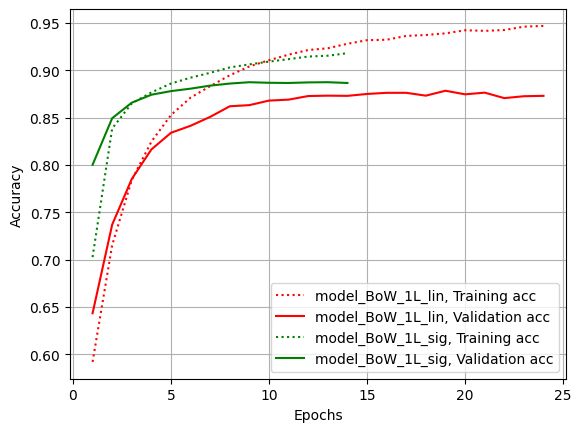

In [31]:
plt.plot(epochs_BoW_1L_lin, train_acc_BoW_1L_lin, 'r:', label='model_BoW_1L_lin, Training acc')
plt.plot(epochs_BoW_1L_lin, val_acc_BoW_1L_lin,   'r',  label='model_BoW_1L_lin, Validation acc')
plt.plot(epochs_BoW_1L_sig, train_acc_BoW_1L_sig, 'g:', label='model_BoW_1L_sig, Training acc')
plt.plot(epochs_BoW_1L_sig, val_acc_BoW_1L_sig,   'g',  label='model_BoW_1L_sig, Validation acc')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Word Embeddings
Until now, we have represented all words as an index (represented as an integer number or as one-hot encoding). This representation does not take similarities in the meaning of words into acocunt - two words are either the same or different.

Using a word embedding, we get a more detailed notion of word similarity. In a high-dimensional representation, the distance between two words will be defined by how similar they are (as infered from the training data). While word embeddings are usually used in connection with more complex models, we start here with a simple network. We just need to add an embedding layer between the encoding and the dense layer:

In [32]:
# initialize random number generators to ensure reproducibility:
tf.random.set_seed(123)
np.random.seed(123)

In [33]:
# Sequence vectorizer for the embedding model
encoderSeq = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN,  # fixed length for batching
)
encoderSeq.adapt(train_ds.map(lambda text, label: text))
vocab_size = len(encoderSeq.get_vocabulary())

**Exercise:** Complete the network below:

In [34]:
# model_embed_seq_1L_sig = Sequential()
# model_embed_seq_1L_sig.add(...)
# model_embed_seq_1L_sig.add(encoderSeq)
# model_embed_seq_1L_sig.add(Embedding(vocab_size, EMBED_DIM, mask_zero=True))
# model_embed_seq_1L_sig.add(GlobalMaxPooling1D())
# model_embed_seq_1L_sig.add(...)

**Solution:**

In [35]:
model_embed_seq_1L_sig = Sequential()
model_embed_seq_1L_sig.add(Input(shape=(1,), dtype='string'))
model_embed_seq_1L_sig.add(encoderSeq)
model_embed_seq_1L_sig.add(Embedding(vocab_size, EMBED_DIM, mask_zero=True))
model_embed_seq_1L_sig.add(Dropout(0.5))
model_embed_seq_1L_sig.add(GlobalMaxPooling1D())
model_embed_seq_1L_sig.add(Dense(1, activation="sigmoid"))

**(End of Solution)**

Note that the model will now learn word embeddings that are optimal for the given task. It's also possible to re-use pretrained word embeddings - see e.g., here fore an example: https://keras.io/examples/nlp/pretrained_word_embeddings/

In [36]:
model_embed_seq_1L_sig.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer=Adam(learning_rate=5e-4),)

In [37]:
model_embed_seq_1L_sig.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 200)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 200, 100)          500000    
                                                                 
 dropout (Dropout)           (None, 200, 100)          0         
                                                                 
 global_max_pooling1d (Glob  (None, 100)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 500101 (1.91 MB)
Trainable params: 50010

In [38]:
history_embed_seq_1L_sig = model_embed_seq_1L_sig.fit(
    train_ds.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE),
    validation_data = val_ds.batch(BATCH_SIZE),
    epochs = NUM_EPOCHS, verbose = 1,
    callbacks = [ EarlyStopping(monitor='val_accuracy', patience=5,
                                verbose=False, restore_best_weights=True)])

Epoch 1/50
40/40 [==============================] - 3s 83ms/step - loss: 0.6867 - accuracy: 0.6551 - val_loss: 0.6841 - val_accuracy: 0.7408
Epoch 2/50
40/40 [==============================] - 3s 83ms/step - loss: 0.6667 - accuracy: 0.7990 - val_loss: 0.6691 - val_accuracy: 0.8114
Epoch 3/50
40/40 [==============================] - 3s 83ms/step - loss: 0.6362 - accuracy: 0.8292 - val_loss: 0.6469 - val_accuracy: 0.8278
Epoch 4/50
40/40 [==============================] - 3s 82ms/step - loss: 0.5953 - accuracy: 0.8363 - val_loss: 0.6175 - val_accuracy: 0.8296
Epoch 5/50
40/40 [==============================] - 3s 82ms/step - loss: 0.5480 - accuracy: 0.8404 - val_loss: 0.5835 - val_accuracy: 0.8332
Epoch 6/50
40/40 [==============================] - 3s 82ms/step - loss: 0.4992 - accuracy: 0.8501 - val_loss: 0.5488 - val_accuracy: 0.8360
Epoch 7/50
40/40 [==============================] - 3s 84ms/step - loss: 0.4556 - accuracy: 0.8522 - val_loss: 0.5169 - val_accuracy: 0.8380
Epoch 8/50
40

40/40 [==============================] - 3s 84ms/step - loss: 0.6892 - accuracy: 0.5617 - val_loss: 0.6862 - val_accuracy: 0.7390
Epoch 2/50
40/40 [==============================] - 3s 84ms/step - loss: 0.6723 - accuracy: 0.7819 - val_loss: 0.6735 - val_accuracy: 0.7830
Epoch 3/50
40/40 [==============================] - 3s 84ms/step - loss: 0.6465 - accuracy: 0.8152 - val_loss: 0.6537 - val_accuracy: 0.8156
Epoch 4/50
40/40 [==============================] - 3s 83ms/step - loss: 0.6100 - accuracy: 0.8343 - val_loss: 0.6272 - val_accuracy: 0.8270
Epoch 5/50
40/40 [==============================] - 3s 82ms/step - loss: 0.5667 - accuracy: 0.8436 - val_loss: 0.5966 - val_accuracy: 0.8302
Epoch 6/50
40/40 [==============================] - 3s 83ms/step - loss: 0.5220 - accuracy: 0.8481 - val_loss: 0.5655 - val_accuracy: 0.8336
Epoch 7/50
40/40 [==============================] - 3s 83ms/step - loss: 0.4825 - accuracy: 0.8554 - val_loss: 0.5367 - val_accuracy: 0.8368
Epoch 8/50
40/40 [======

In [39]:
# Evaluate Training Progress
history_embed_seq_1L_sig_dict = history_embed_seq_1L_sig.history

train_acc_embed_seq_1L_sig_dict = history_embed_seq_1L_sig_dict['accuracy']
val_acc_embed_seq_1L_sig_dict   = history_embed_seq_1L_sig_dict['val_accuracy']
epochs_embed_seq_1L_sig_dict    = range(1, len(train_acc_embed_seq_1L_sig_dict) + 1)

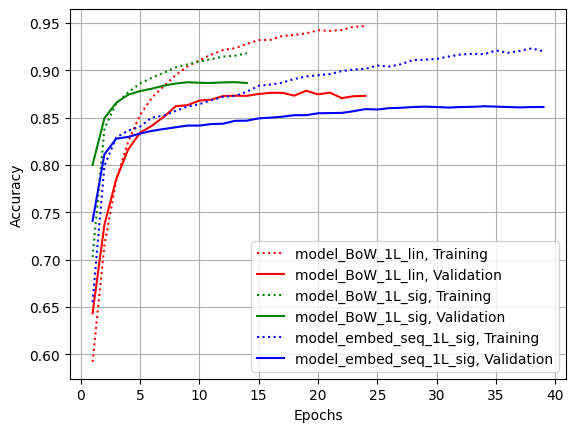

In [40]:
plt.plot(epochs_BoW_1L_lin, train_acc_BoW_1L_lin, 'r:', label='model_BoW_1L_lin, Training')
plt.plot(epochs_BoW_1L_lin, val_acc_BoW_1L_lin,   'r',  label='model_BoW_1L_lin, Validation')

plt.plot(epochs_BoW_1L_sig, train_acc_BoW_1L_sig, 'g:', label='model_BoW_1L_sig, Training')
plt.plot(epochs_BoW_1L_sig, val_acc_BoW_1L_sig,   'g',  label='model_BoW_1L_sig, Validation')

plt.plot(epochs_embed_seq_1L_sig_dict, train_acc_embed_seq_1L_sig_dict, 'b:', label='model_embed_seq_1L_sig, Training')
plt.plot(epochs_embed_seq_1L_sig_dict, val_acc_embed_seq_1L_sig_dict,   'b',  label='model_embed_seq_1L_sig, Validation')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The plot shows us several things:
* Using Embeddings, we achieve good results with less training epochs. However, each epoch takes longer (as we also have to train the embeddings!)

The `GlobalMaxPooling1D` layer largely reduces the number of parameters, and thus avoids too much overfitting, while still improving the performance of the model. If you are interested, experiment with the network architecture, e.g. by omitting the `GlobalMaxPooling1D`, and see how the model performance is changing.

The next step will be to take into account the order of the words, which we currently still ignore.